In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

2024-11-11 20:55:16.572044: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 20:55:16.572485: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 20:55:16.574684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 20:55:16.580551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731338716.590806 1525475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731338716.59

## Data Import and Processing

In [2]:
X = np.loadtxt('training_data_noutliers/training_samples.txt')
y = np.loadtxt('training_data_noutliers/chisqs.txt')

In [3]:
val_frac, test_frac = 0.2, 0.2
total = val_frac + test_frac

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=total, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_frac/total), random_state=42)

## Model Creation and Training

### Without normalization layer

In [5]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])

temp_model = tf.keras.Sequential([
    input_layer,
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
temp_model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
temp_history = temp_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=0)

2024-11-11 20:56:01.921186: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


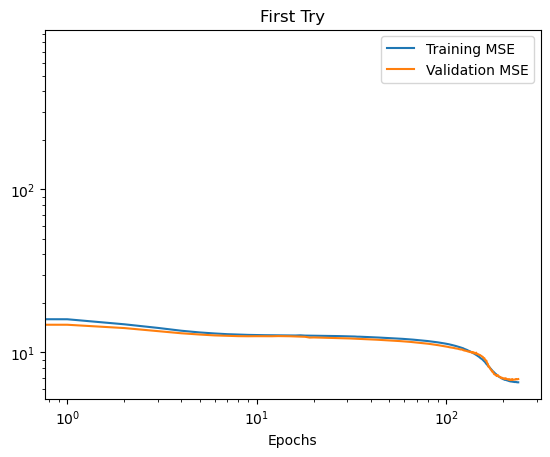

In [6]:
plt.plot(temp_history.history['loss'], label='Training MSE')
plt.plot(temp_history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('First Try')
plt.legend()
plt.xlabel('Epochs')

plt.savefig('plots/First_Try.png',dpi=300,bbox_inches='tight')

In [7]:
temp_test_loss, temp_test_mse = temp_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - MeanSquaredError: 5.7609 - loss: 5.8112


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


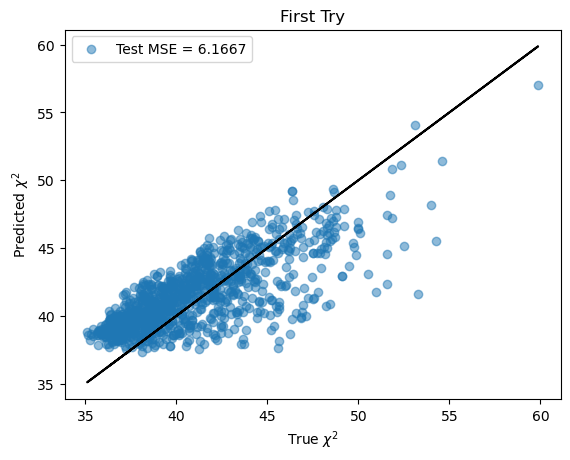

In [8]:
plt.scatter(y_test, temp_model.predict(X_test), label=f'Test MSE = {temp_test_mse:.4f}', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.title('First Try')
plt.legend()
plt.savefig('plots/First_Try_Test.png',dpi=300,bbox_inches='tight')

### With normalization layer

In [9]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

model = tf.keras.Sequential([
    input_layer,
    norm_layer,
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=0)

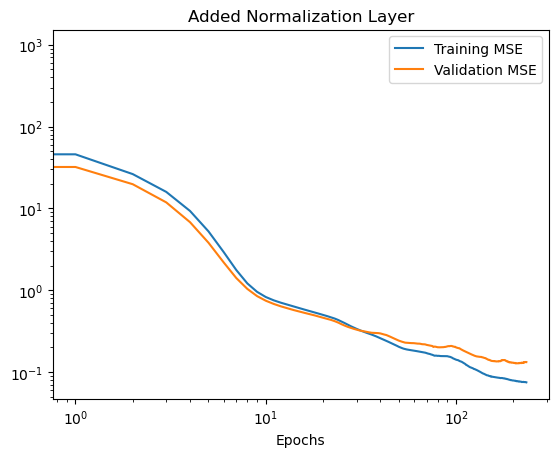

In [10]:
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('Added Normalization Layer')
plt.legend()
plt.xlabel('Epochs')
plt.savefig('plots/Added_Normalization_Layer.png',dpi=300,bbox_inches='tight')

In [11]:
init_test_loss, init_test_mse = model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - MeanSquaredError: 0.1459 - loss: 0.1596


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


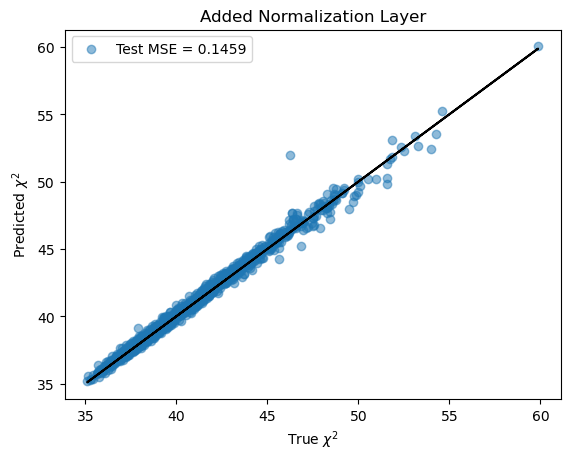

In [12]:
plt.scatter(y_test, model.predict(X_test), label=f'Test MSE = {init_test_mse:.4f}', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.title('Added Normalization Layer')
plt.legend()
plt.savefig('plots/Added_Normalization_Layer_Test.png',dpi=300,bbox_inches='tight')

### Tuned Model

In [13]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

best_model = tf.keras.Sequential([
    input_layer,
    norm_layer,
    tf.keras.layers.Dense(400, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
best_model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=1)

Epoch 1/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanSquaredError: 1665.6022 - loss: 1665.6287 - val_MeanSquaredError: 1501.2031 - val_loss: 1501.2303
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - MeanSquaredError: 1335.6829 - loss: 1335.7102 - val_MeanSquaredError: 670.6500 - val_loss: 670.6783
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - MeanSquaredError: 449.4748 - loss: 449.5039 - val_MeanSquaredError: 75.4504 - val_loss: 75.4810
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - MeanSquaredError: 71.3122 - loss: 71.3428 - val_MeanSquaredError: 55.0249 - val_loss: 55.0556
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - MeanSquaredError: 55.6381 - loss: 55.6688 - val_MeanSquaredError: 46.7669 - val_loss: 46.7975
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - MeanSquaredError: 46.7300 - loss: 46.7606 - val_MeanSquaredError: 40.5731 - val_loss: 40.6036
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - MeanSquaredError: 40.0793 - lo

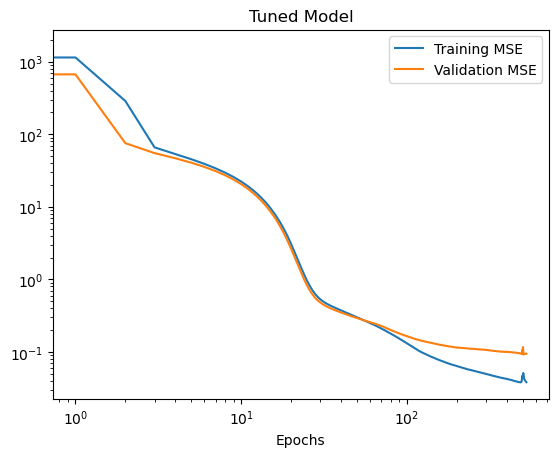

In [14]:
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('Tuned Model')
plt.legend()
plt.xlabel('Epochs')
plt.savefig('plots/Tuned_Model.png',dpi=300,bbox_inches='tight')

In [15]:
best_test_loss, best_test_mse = best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - MeanSquaredError: 0.0801 - loss: 0.1044


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


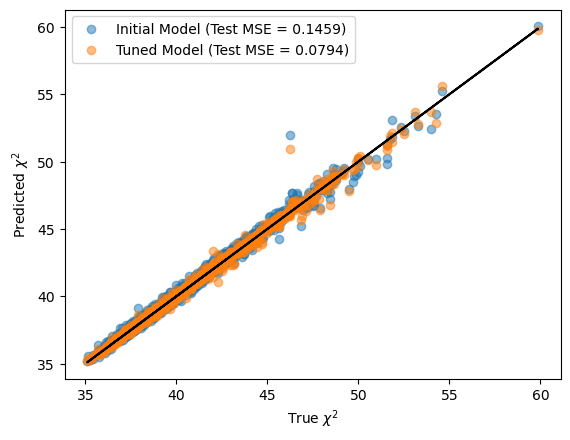

In [16]:
plt.scatter(y_test, model.predict(X_test), label=f'Initial Model (Test MSE = {init_test_mse:.4f})', alpha=0.5)
plt.scatter(y_test, best_model.predict(X_test), label=f'Tuned Model (Test MSE = {best_test_mse:.4f})', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.legend()
plt.savefig('plots/Tuned_Model_Test.png',dpi=300,bbox_inches='tight')

In [17]:
best_model.save('script_chisq_emulator_noutliers_256_32.keras')